Study the relationship between the velocity width of HI detections and the distance to the nearest neighbor for MaNGA galaxies.

### Imports

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from scipy.spatial import KDTree

# Data

In [57]:
mangaHIall_filename = 'input/mangaHIall_classified_corrected_with_Mstar+MHI'
mangaHIall = Table.read(mangaHIall_filename, format = 'ascii.commented_header')

# Find distance to nearest neighbor for each MaNGA galaxy

For each galaxy in the MaNGA data table, find its nearest neighbor and calculate the distance to that galaxy.
1. Calculate the distance to every galaxy in SDSS DR7 for each MaNGA galaxy with an HI detection.
2. Find the galaxy with the smallest distance - this is our nearest neighbor!  (Note: We need to check to make sure that we do not identify the MaNGA HI target galaxy as the nearest neighbor.)

### Convert (ra, dec, redshift) to (x, y, z)

Since we are going to do this for both the KIAS galaxies and the MaNGA galaxies, let's write a function.

In [58]:
c = 3e5 #3*(10**8) m/s <-- Scientific notation
H = 100 #2.43 * (10**-18) 1/s <-- We are doing to do all of our distances in Mpc/h (where H0 = 100h).

def rdz_to_xyz(data):
    '''
    Convert ra, dec, redshift to x, y, z
    
    
    PARAMETERS
    ==========
    
    data : astropy table
        Galaxies to analyze.  Columns include ra, dec, redshift.
        
        
    RETURNS
    =======
    
    data : astropy table
        Same as input data object, with the additional fields of x, y, z
    '''

    '''
    # We can do this all at once, since we are doing the same calculation on every 
    # row of the data table.
    
    for i in range(len(data)):
        radius_2 = c*data['redshift']/H
        r_2 = radius_2
        x_2_cor = r_2 * np.cos(kias7['ra'][i]* np.pi/180) * np.cos(kias7['dec'][i]* np.pi/180)
        y_2_cor = r_2 * np.sin(kias7['ra'][i]* np.pi/180) * np.cos(kias7['dec'][i]* np.pi/180)
        z_2_cor = r_2 * np.sin(kias7['ra'][i]* np.pi/180)
        x_2.append(x_2_cor)
        y_2.append(y_2_cor)
        z_2.append(z_2_cor)
    '''
    
    ################################################################################
    # Our data tables have different column names, so we need to determine the 
    # correct names.
    #-------------------------------------------------------------------------------
    if 'redshift' in data.colnames:
        redshift = data['redshift']
        ra = data['ra'] * np.pi/180
        dec = data['dec'] * np.pi/180
    elif 'NSA_redshift' in data.colnames:
        redshift = data['NSA_redshift']
        ra = data['NSA_RA'] * np.pi/180
        dec = data['NSA_DEC'] * np.pi/180
    else:
        print('Unknown field names.  Add to rdz_to_xyz function and rerun.')
        return data
    ################################################################################
    
    
    ################################################################################
    # Convert from spherical to cartesian coordinates
    #-------------------------------------------------------------------------------
    r = c*redshift/H
    
    data['x'] = r * np.cos(ra) * np.cos(dec)
    data['y'] = r * np.sin(ra) * np.cos(dec)
    data['z'] = r * np.sin(dec)
    ################################################################################
    
    return data

In [59]:
# Now that we have our function written, we can do this conversion on both data tables
mangaHIall = rdz_to_xyz(mangaHIall)
kias7 = rdz_to_xyz(kias7)

### Calculate distance between galaxies and find the closest one

In [60]:
# Generates x_tree, y_tree, z_tree array for kias7
x_tree = np.asarray(kias7['x'])
x_tree = x_tree.astype(np.float64)
x_tree = x_tree.reshape(x_tree.shape[0],1)
y_tree = np.asarray(kias7['y'])
y_tree = y_tree.astype(np.float64)
y_tree = y_tree.reshape(y_tree.shape[0],1)
z_tree = np.asarray(kias7['z'])
z_tree = z_tree.astype(np.float64)
z_tree = z_tree.reshape(z_tree.shape[0],1)
xyz_tree = np.concatenate((x_tree,y_tree,z_tree), axis=1)

# Generates x_query, y_query, z_query array for manga
x_query = np.asarray(mangaHIall['x'])
x_query = x_query.astype(np.float64)
x_query = x_query.reshape(x_query.shape[0],1)
y_query = np.asarray(mangaHIall['y'])
y_query = y_query.astype(np.float64)
y_query = y_query.reshape(y_query.shape[0],1)
z_query = np.asarray(mangaHIall['z'])
z_query = z_query.astype(np.float64)
z_query = z_query.reshape(z_query.shape[0],1)
xyz_query = np.concatenate((x_query,y_query,z_query), axis=1)

In [61]:
# Generate KDTree for kias7
tree = KDTree(xyz_tree)

In [62]:
nearest_distances, _ = tree.query(xyz_query, k=2)
nearest_distances = nearest_distances[:,1]

In [63]:
mangaHIall['d_nn'] = np.zeros(len(mangaHIall), dtype=float)
mangaHIall['d_nn'] = nearest_distances

### WF50 vs Distance to nearest neighbor plot

In [64]:
walls_data_boolean = np.isfinite(mangaHIall['HI-walls'])  
walls_data = mangaHIall[walls_data_boolean]

voids_data_boolean = np.isfinite(mangaHIall['HI-voids']) 
voids_data = mangaHIall[voids_data_boolean]

In [65]:
walls_WF50 = walls_data['WF50_corrected']
walls_dnn = walls_data['d_nn']

voids_WF50 = voids_data['WF50_corrected']
voids_dnn = voids_data['d_nn']

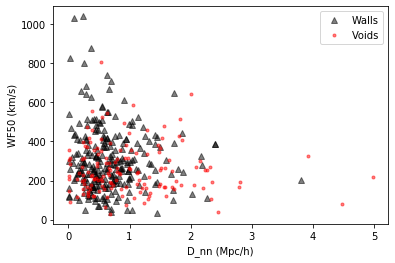

In [66]:
plt.plot(walls_dnn, walls_WF50, '^', color = 'black', label = 'Walls', alpha = 0.5)
plt.plot(voids_dnn, voids_WF50, '.',color = 'red', label = 'Voids', alpha = 0.5)
plt.ylabel('WF50 (km/s)')
plt.xlabel('D_nn (Mpc/h)')
plt.legend()
plt.savefig('plots/logWF50-D_nn.svg', dpi=500, facecolor='w', edgecolor='w',
        orientation='portrait', format='svg', pad_inches=0.1)
plt.savefig('plots/logWF50-D_nn.jpeg', dpi=500, facecolor='w', edgecolor='w',
        orientation='portrait', format='jpeg', pad_inches=0.1)

plt.show()